## **0. What is `cbeam`?**

`cbeam` ("coupled-beam") simulates the propagation of light through slowly-varying tapered waveguides using the coupled-mode approach. When applicable, this approach is faster than alternate techniques like the finite difference beam propagation method (FD-BPM). `cbeam` is mostly written in Python, and has a completely Pythonic interface, with some parts written in Julia. In this notebook, we'll go over installation instructions, provide basic documentation, and give some starting examples.

## **1. Basics**

#### **1.1 How to install**
Right now, `cbeam` is not packaged (though it will be in the future). For now,  install by cloning the Github repo. You will need both a Python3 and a <a href="https://julialang.org/downloads/">Julia</a> installation. Below are the following dependencies:

**General**: `Gmsh` (download <a href="https://gmsh.info/">here</a>)

**Python**: `numpy`,`scipy`,`juliacall`,`wavesolve`,`pygmsh`,`meshio`,`matplotlib` <br> (All `pip` installable besides `wavesolve`, download <a href="https://github.com/jw-lin/wavesolve">here</a>)

**Julia**: `PythonCall`, `StaticArrays`, `GrundmannMoeller` <br>
To install the Julia packages, after cloning `cbeam`, start a Julia REPL in the root directory and run the following:

```
using Pkg
Pkg.activate("FEval")
Pkg.add("PythonCall")
Pkg.add("StaticArrays")
Pkg.add("GrundmannMoeller")
exit()
```

When updating, if a change has been made to the Julia source code, you will have to re-run the above (and most likely delete the auto-generated `Manifest.toml` file and `.CondaPkg` folder in the `FEval` directory beforehand, if they exist.)

#### **1.2 How it works**

Below we provide a high-level overview of how the code works.

**1.** To solve for the instantaneous eigenmodes of the waveguide at a given $z$ coordinate (which we define as the propagation direction), we use `wavesolve`, a Python package that applies the finite element method over quadratic triangle meshes.

**2.** To generate meshes corresponding to the waveguide refractive index profile at $z$, we use `pygmsh`/`Gmsh`. **Only waveguides with step-index profiles are currently supported**, although it should be possible to extend to gradient index waveguides in the future.

**3.** To simulate slowly-varying waveguides, meshes are continuously evolved forward in $z$ by applying a transformation to all mesh points. **Only waveguides that can be represented this way are fully supported**. (Though it can be possible to simulate other kinds of waveguides with a little more work, and I plan on extending functionality in the future.)

**4.** In order to quickly evaluate a FE mode field at an arbitrary $(x,y)$ point, `cbeam` includes `FEval`, a simple Julia package that implements bounding volume hierarchy (BVH) trees. These structures are used to store mesh triangles, for faster lookup.

**5.** To quickly integrate functions involving FE modes (i.e. to take inner products), we use the `GrundmanMoeller` Julia package.

**6.** The initial value problem corresponding to the coupled-mode equations is solved using standard Runge-Kutta schemes, as implemented through `SciPy`.

#### **1.3 Code structure**

`cbeam` provides the following modules.

> `waveguide` : one of two main modules, used to define waveguides.

> `propagator` : the second main module, used to define propagation parameters and run propagations.

> `FEval` : the "finite element evaluation" module, comprised of Julia source code and a Python wrapper unless you want to resample eigenmodes (e.g. onto rectangular grids).

#### **1.4 Known issues**

The code seems functional. However, it's at least anecdotally clear that certain mesh geometries (for the same waveguide) lead to fast computations, while other geometries will be much slower. As of now there is no way of telling whether a mesh is "good" or "bad", other than by explicitly running the propagator. Unfortunately, I don't have a better solution yet. Ideas welcome.

Another issue is that it's hard to tell what sort of resolution simulations need to be run out to produce accurate results. When $z$-stepping is too loose, or the FE mesh to coarse, the code will happily give you wrong answers. As is the case with most numerical modelling packages. Still, it should be possible to make things more bulletproof.

## **2. How to use `cbeam`**

Broadly speaking, using `cbeam` is a two-step process: we first define a waveguide using the `waveguide` module, and then we simulate propagation with the `propagator` module.


### **2.1 Defining waveguides**

In this section we discuss how to build waveguides from the bottom-up. In practice, users may only need to interact with the high-level `Waveguide` class covered in Section 2.1.3.

#### **2.1.1** *the `Prim2D` class*

The most basic parent class that represents a refractive index geometry is a `Prim2D`. Each `Prim2D` specifies the boundary of a closed region - through an array of $(x,y)$ points - and a refractive index value corresponding to the interior that region. Physically, these boundaries represent material interfaces in the waveguide. A `Prim2D` is generically initialized through

`prim2D = waveguide.Prim2D(points,n)`

**Arguments**

1. `points` : an $N\times 2$ array of $(x,y)$ points corresponding to a material interface. (The first and last point are automatically connected.)
2.  `n` : the refractive index inside the region bounded by `points`. 

To simulate complex waveguide geometries, users are encouraged to define subclasses that inherit from `Prim2D`. Such classes can have there own `__init__()` functions, but should implement a function `make_points()`, which takes in some arguments and returns an array `points`.  The two subclasses currently implemented are `Circle` and `Rectangle`.

Two `Prim2D` objects can be unioned to form a new `Prim2D` object using `waveguide.Prim2DUnion` class, which inherits from `Prim2D`. This class automatically has a `make_points()` defined, e.g.

```
union = waveguide.Prim2DUnion(prim1,prim2)
union_points = union.make_points(args1,args2)
```

where the argument tuple `args1` corresponds to `prim1.make_points(*args1)` and similarly for `args2`. 

#### **2.1.2** *the `Prim3D` class*

The next level in complexity is the `Prim3D` parent class, which combines a `Prim2D` with rules that define evolution with respect to $z$. A `Prim3D` is generically initialized as 

`prim3D = waveguide.Prim2D(prim2D,label)`

**Arguments**

1. `prim2D` : a `Prim2D` object representing the cross-section of the `Prim3D`
2. `label` : a user-specified identifying string to attach to the physical region bounded by `prim2D.points` (e.g. "core" or "cladding" for a step-index fiber.)

Inheriting classes must implement the function `update(z)`, which updates `prim2D` to the desired $z$ coordinate. The two subclasses currently implemented are `Pipe`, which can be used to represent geometries where the cross-section remains circular at all $z$, and `InfiniteBox`, which describes a `Rectangle` that does not change with $z$.

`Prim3D` objects also have two optional properties: `mesh_size` and `skip_refinement`. The former numeric property sets a finite element size (triangle side length) for the meshing algorithm, inside the bounded region, while the latter boolean property will control if triangles near the boundary should be adaptively refined.

#### **2.1.3** *the `Waveguide` class*

A `Waveguide` stores a (potentially nested) list of `Prim3D`s, which we will call `prim3Dgroups`. The refractive index profile of each top-level element in `prim3Dgroups` is overwritten by the immediate next element. Any element containing a list of `Prim3D`s is treated as a single `Prim3D`.* So, an optical fiber might store its primitives as `[cladding,core]`, where `cladding` and `core` are `Pipe`s corresponding to the cladding and core regions; a multicore fiber could have the structure `[cladding,[core1,core2,...]]`. A `Waveguide` is generically initialized as 

`wvg = Waveguide(prim3Dgroups)` 

**Arguments** 

1.  `prim3Dgroups` : the potentially nested list of 3D primitives mentioned above.

All `Waveguide` objects have four predefined class functions:

> `update(z)` : this function updates the waveguide to a given $z$ coordinate. The base behavior of this function is to call `update` on every `Prim3D` in the waveguide.

> `make_mesh()` : this function returns a quadratic triangle finite element mesh corresponding to the cross-sectional structure of the waveguide at the current $z$ coordinate.

> `make_mesh_bndry_ref()` : similar to `make_mesh()` but will adaptively adaptively refine the mesh in regions near material interfaces, respecting the `mesh_size` and `skip_refinement` properties of all `Prim3D`s in the `Waveguide`.

> `assign_IOR()` : this function returns a dictionary `IOR_dict` that maps each labelled region in the mesh to a refractive index value. The keys of this dictionary are the labels of the `Prim3D` objects composing the waveguide.

It is also *highly recommended* for  `Waveguide` subclasses to implement the following function:

> `transform(x0,y0,z0,z)` : this function takes a point $(x0,y0,z0)$ and returns a new point $(x,y)$ at the longitudinal coordinate $z$. This transformation is used give $z$ dependence to the mesh geometry in a continuous manner.

If the above function is not implemented, then the propagator will construct a new mesh at every new value of $z$. This mode will only work if:

1. There is **no** eigenvalue splitting or joining throughout the entire waveguide. The numerically-computed eigenmodes do not vary continuously in such cases.
2. The degenerate modes of the waveguide (which must remain degenerate throughout the entire waveguide) are known beforehand and passed into the propagator (more on this in Section 2.2.2).

*`Prim3D` objects in the same sublist should never intersect. However, they can have different `label`s and refractive indices. If you want to construct an object formed from the union of two simpler objects, you should make a `Prim2DUnion`, and then apply some $z$-dependence to make a custom `Prim3D`.

#### **2.1.4** *example waveguides - the `PhotonicLantern` and the `Dicoupler`*

One example of a `Waveguide` subclass is the `PhotonicLantern` class. This waveguide is composed of the following primitives: a single outer `Pipe` corresponding to the lantern jacket, a single inner `Pipe` corresponding to the lantern cladding, and a set of small `Pipe`s embedded within the cladding - the cores. These primitives are arranged as `[jacket,cladding,[core1,core2,...]]`. This class has a custom `__init__()` function which automatically generates and arranges `Pipe`s based on parameters like core radius, cladding radius, and core position(s). The `transform()` function applies a simple uniform scaling in $(x,y)$. See `waveguide.PhotonicLantern` for more details. 

Another example is the `Dicoupler` class, which can be used to model both symmetric and asymmetric two-channel directional couplers. A `Dicoupler` is composed of three `InfiniteBox`es (together forming the cladding) and two `Pipe`s (the cores). The `transform()` function applies a simple $x$ scaling in the rectangular region between the two cores, and translates the left and right regions inwards/outwards, accordingly. Note that the cladding is split into 3 parts, along the transformation boundaries, for minimum core separation $d$ and core radius $r$, to avoid destroying the finite elements. The structure is `[[clad_left,clad_middle,clad_right],[core_left,core_right]]`. See `waveguide.Dicoupler` for more details.

#### **2.1.5** *utility functions for `Waveguides`*
Below we list some useful functions implemented by the base `Waveguide` class.

> `plot_boundaries()` : plot all boundaries (material interfaces) in the waveguide, at the currently updated $z$ coordinate.

> `plot_mesh()` : generate and plot a mesh for the waveguide. You can also explicitly pass in a mesh, produced e.g. by `Waveguide.make_mesh()`, as well as refractive index information, through the optional args `mesh` and `IOR_dict`.

### **2.2 Propagation - the `Propagator` class**

Propagation is controlled via the `Propagator` class. 

#### **2.2.1** *initialization*

Below is the pattern for initialization: 

`prop = propagator.Propagator(wl,wvg,Nmax,save_dir)`

**Arguments**

1.  `wl` : the propagation wavelength (in the same spatial unit that the waveguide geometry is defined in)
2. `wvg` : a `Waveguide` object
3. `Nmax` : the number of propagating modes in this waveguide (we cannot at the moment treat radiative modes)
4. `save_dir` : the local path for where data should be saved. The default is `"./data"`. Folders will be created if they are not found.

#### **2.2.2** *"characterizing" the waveguide*

Before we can apply coupled-mode theory to simulate the waveguide we have loaded, we need to pre-compute the following waveguide properties, as a function of $z$:
* the instanteous eigenmodes
* the instanteous eigenvalues
* the cross-coupling matrix (formed from the inner product of eigenmodes and eigenmode derivatives.)

This step takes the bulk of the time when it comes to waveguide simulation; however, once we have the above, propagation of any guided wavefront through the waveguide is fast. To do this setup, we use the function `prop.prop_setup()`, which will adaptively step forwards in $z$ and compute the required items. Below is the function pattern:

`prop.prop_setup(zi,zf)`

**Arguments**

1. `zi` : the starting $z$ coordinate to compute the eigenmodes, eigenvalues, and cross-coupling matrix. Does not have to be 0.
2. `zf` : the ending $z$ coordinate, which does not have to be the maximum extent of the waveguide.

There are also a number of optional arguments related to computation details.

**Optional arguments**

3. `tol` : this tolerance parameter controls the adaptive stepping. Smaller = more careful stepping. Values are typically in the 1e-4 to 1e-6 range (default 1e-5).
4. `dz0` : this is the fixed $z$ step used to estimate derivatives via centered finite difference. Default is 0.1, but might need to be changed depending on your choice of spatial units.
5. `min_zstep` : this is the minimum `z` step that can be chosen by the adaptive scheme. This is particularly useful for waveguide that do not evolve smoothly: the adaptive-stepping might not be able to converge properly at "kinks" in the waveguide structure.
6. `max_zstep` : this is the maximum `z` step that can be chosen by the adaptive scheme. This is useful to prevent the adaptive stepper from skippin over small, peaked features in the cross-coupling matrix. 
7. `fixed_step` : set this to a numeric value to used a fixed $z$ step, bypassing the adaptive scheme.
6. `save` : set to True to write all computation results to file. These can be loaded later with `prop.load(tag)`, where `tag` is defined as below
7. `tag` : a string tag to attach to output files so that they can be loaded later.
8. `mesh` : explicitly pass in a starting mesh (generated from `Waveguide.make_mesh()` or similar) if you don't want to use an auto-generated one.
9. `mode` : either `"transform"` or `"remesh"`. In `"transform"` mode, the $z$-dependence of the waveguide is modelled by applying the `Waveguide.transform()` function to the starting mesh points. In `"remesh"` mode, a new mesh is made for every value of $z$.
10. `degen_groups` : a nested list of indices (starting from 0) which identify degenerate mode groups. For instance, if we know *a priori* that modes (1,2) and modes (3,4) form degenerate pairs, we could pass in `[[1,2],[3,4]]`. In transform mode, this can speed up computation: in remesh mode, this is necessary.
11. `plot` : set True if you want to see the starting mesh and initial eigenmodes. Can be good for sanity checking. Default `False`.


#### **2.2.3** *propagation*

Once `prop_setup()` has been run, or files produced by a previous setup have been loaded with `prop.load(tag)`, we can simulate light propagation. The first step is to quickly generate interpolation functions for the eigenmodes, eigenvalues, and cross-coupling matrix over $z$. This is done with:

`prop.make_interp_funcs()`

This function will create interpolation functions that allow us to compute the cross-coupling matrix, eigenmodes, eigenvalues, and eigevalue derivative/antiderivatives, as a function of $z$, which will be used later to solve the coupled-mode equations. Specifically, `prop.make_interp_funcs()` will enable the following functions

> `prop.compute_cmat(z)` : returns the cross-coupling matrix (an $N\times N$ antisymmetric matrix) as a function of $z$.

> `prop.compute_v(z)` : returns the eigenmode basis (an $M\times N$ array for $M$ mesh points and $N$ eigenmodes) as a function of $z$.

> `prop.compute_neff(z)` : returns the effective refractive indices (an $N\times 1$ array) as a function of $z$. The mode effective index $n_e$ is related to the eigenvalue $w$ is related to by $n_e = \sqrt{w/k^2}$, where $k$ is the free space wavenumber.

> `prop.compute_dif_neff(z), prop.compute_int_neff(z)` : returns the derivative and antiderivative `compute_neff(z)`.


From here, we can define a launch field, expressed in the basis of the initial eigenmodes of the waveguide, e.g. 

`u0 = [1,0,0,...]`

and the propagate the field using `prop.propagate()`. The pattern is as follows:

`z,u,uf = prop.propagate(u0,zf,WKB)`

Arguments 

1. `u0` : the launch wavefront, expressed in the basis of the initial eigenmodes.
2. `zf` : the ending $z$ coordinate for propagation
3. `WKB` : (optional), a boolean which controls whether or not an additional minor correction is included in the coupled-mode equations (default `True`)

Returns

1. `z` : an array of $z$ values selected by the IVP solver (`scipy.integrate.solve_ivp`, RK23 scheme).
2. `u` : an `Nmax` $\times$ `M` array of mode amplitudes computed at each of the `M` values of `z` (with fast $e^{i\beta z}$ oscillation factored *out*).  
3. `uf` : the final mode amplitudes (with fast $e^{i\beta z}$ oscillation factored *in* - these are the actual complex-valued mode amplitudes at `zf`).


## **3. Worked example: 6-port photonic lantern**
Below I include some code which uses `cbeam` to simulate the propagation of the ${\rm LP}_{01}$ mode through a "standard" (uniform core size) 6-port photonic lantern. Below, we define all the waveguide and simulation parameters.

In [6]:
### lantern propagation sim params ###

import numpy as np

wl = 1.55                       # wavelength, um
taper_factor = 12.              # relative scale factor between frontside and backside waveguide geometry    
rcore = 2.2/taper_factor        # radius of tapered-down single-mode cores at frontside, um
rclad = 10                      # radius of cladding-jacket interface at frontside, um
rjack = 30                      # radius of outer jacket boundary at frontside, um
z_ex = 20000                    # lantern length, um

nclad = 1.444                   # cladding refractive index
ncore = nclad + 8.8e-3          # SM core refractive index
njack = nclad - 5.5e-3          # jacket refractive index

t = 2*np.pi/5                   
core_offset = rclad*2/3         # offset of outer ring of cores from center

# initial core positions. the first core is at (0,0) and the other 5 form a pentagon
core_pos = np.array([[0,0]] + [[core_offset*np.cos(i*2*np.pi/5) , core_offset*np.sin(i*2*np.pi/5)] for i in range(5)])

# mesh params #

core_res = 60                      # no. of line segments to use to resolve the core-cladding interface(s)
clad_res = 120                     # no. of line segments to use to resolve the cladding-jacket interface
jack_res = 30                      # no. of line segments to form the outer jacket boundary
clad_mesh_size = 2.0               # mesh size (triangle side length) to use in the cladding region
core_mesh_size = 0.2               # mesh size (triangle side length) to use inside the cores

# solve params #

tol = 1e-4                         # accuracy parameter. lower = slower.
max_zstep = 320                    # maximum step in z that can be chosen by the adaptive algorithm
min_zstep = 1.25                   # minimum step in z that can be chosen by the adaptive algorithm

degen_groups = [] # note that modes [1,2] and [3,4] for degenerate pairs ... but we leave this unspecified for now.

std_rcores = np.array([rcore]*6)    # core radii
ncores = [ncore]*6                  # core index

Next, we initialize our `PhotonicLantern` object (yes there are a lot of args ...)

In [7]:
import waveguide
lant = waveguide.PhotonicLantern(core_pos,std_rcores,rclad,rjack,ncores,nclad,njack,z_ex,taper_factor,core_res,clad_res,jack_res,core_mesh_size,clad_mesh_size)

Let's use the built-in `plot_boundary` and `update` functions to look at the waveguide structure. 

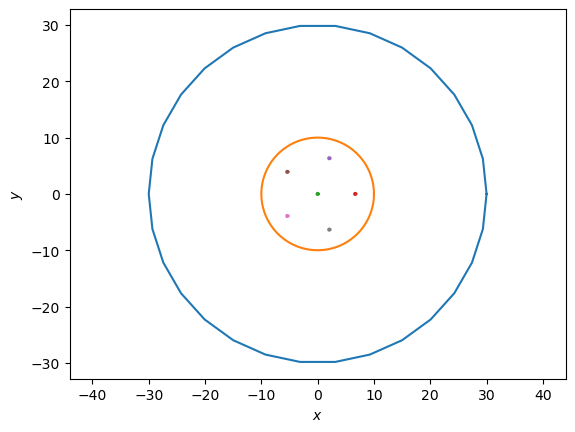

In [8]:
lant.update(0) # set z = 0, lantern entrance
lant.plot_boundaries()

Next, we initialize a `Propagator` object ...

In [9]:
import propagator
prop = propagator.Propagator(wl,lant,6)

Compute the eigenmodes, eigenvalues, and cross-coupling matrices of the waveguide for $z\in $[0,`z_ex`], and save it to `"test_6PL"`.

generating mesh...
number of mesh points:  5255
initial mesh: 


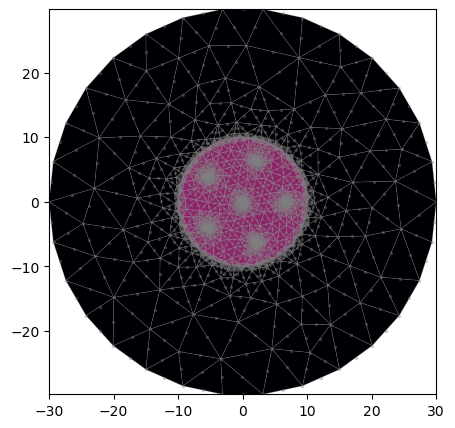

initial modes: 
effective index:  1.443176746355282


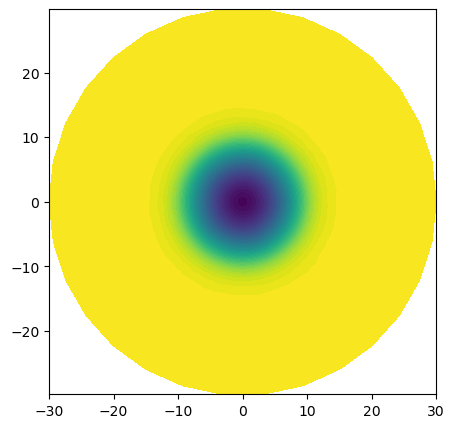

effective index:  1.4419051995939574


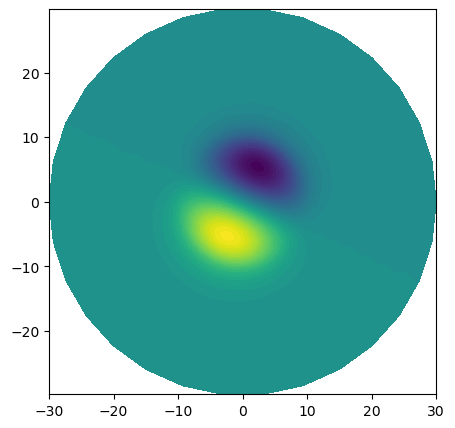

effective index:  1.4419051562024892


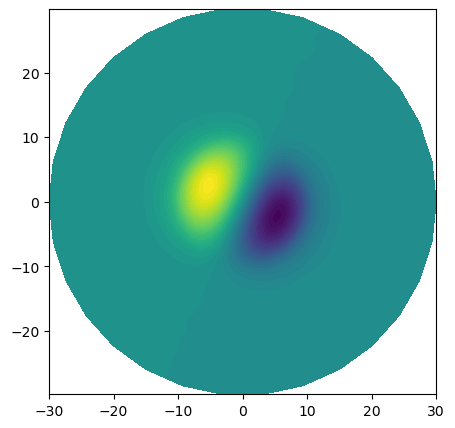

effective index:  1.4402954203352258


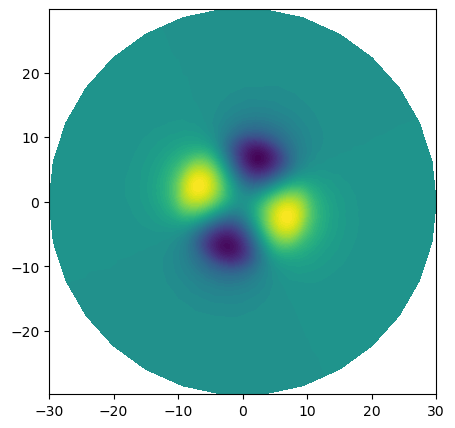

effective index:  1.4402953284364508


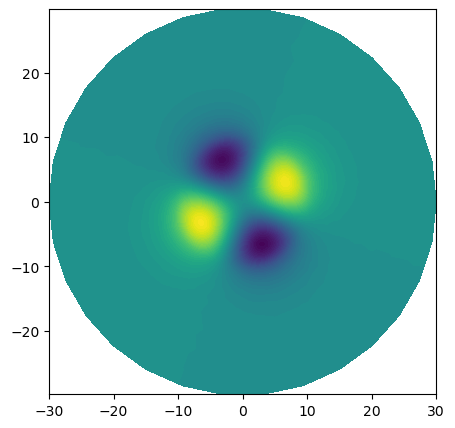

effective index:  1.4398279593494834


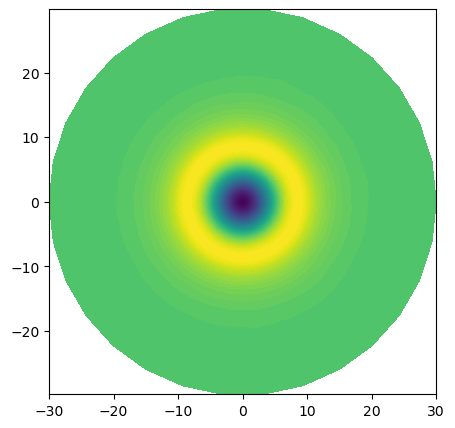

starting computation ...
current z: 20000.0 / 20000 ; current zstep: 160.0        time elapsed:  1334.520103931427


In [10]:
# this'll take like 45 minutes ...

output = prop.prop_setup(0,z_ex,tol,save=True,tag="test_6PL",degen_groups=degen_groups,min_zstep=min_zstep,max_zstep=max_zstep,plot=True)

# can also load with 
# prop.load(tag="test")

Next, we make the interpolation functions. We can use these interpolation functions to look at the effective index evolution of the eigenmodes through the waveguide.

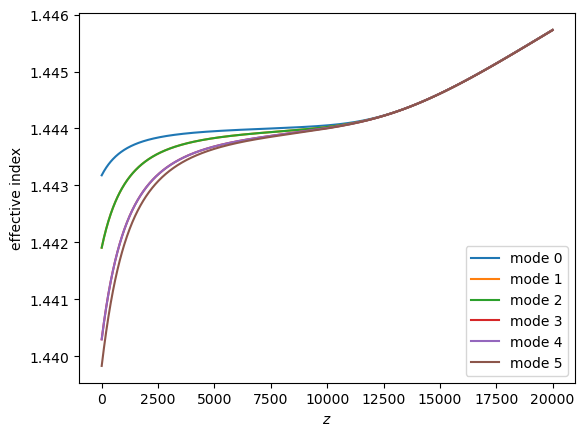

In [14]:
prop.make_interp_funcs()

zs = np.linspace(0,z_ex,1000)

import matplotlib.pyplot as plt
neffs = prop.compute_neff(zs)
for i in range(6):
    plt.plot(zs,neffs[i],label="mode "+str(i))
plt.xlabel(r"$z$")
plt.ylabel("effective index")
plt.legend(loc='best')
plt.show()

Finally, let's propagate the ${\rm LP}_{01}$ mode (which has the highest eigenvalue and is therefore the first eigenmode at the waveguide entrance). Due to the rotational symmetry of the lantern, we should expect to find that same symmetry in the lantern outputs if we inject in a rotationally invariant mode like the ${\rm LP}_{01}$ mode. Below we plot the eigenmode amplitudes as a function of $z$.

final mode amplitudes: 
[0.71811305 0.30889218 0.30896356 0.30896182 0.30893762 0.30882921]
final mode powers: 
[0.51568636 0.09541438 0.09545848 0.09545741 0.09544245 0.09537548]


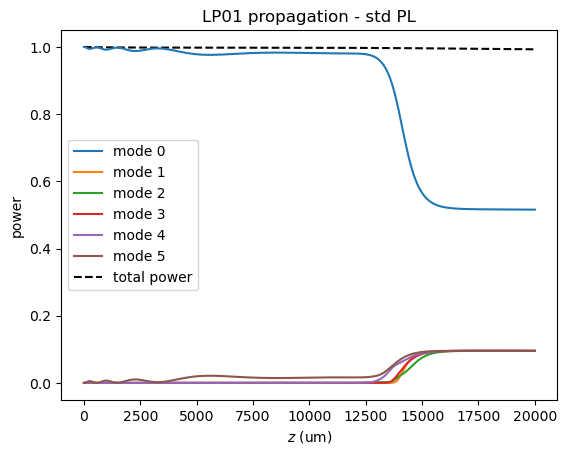

In [12]:
u0 = [1,0,0,0,0,0] # launch field, LP01

z,u,uf = prop.propagate(u0,z_ex,WKB=True)

print("final mode amplitudes: ")
print(np.abs(uf))
print("final mode powers: ")
print(np.power(np.abs(uf),2))

import matplotlib.pyplot as plt
for i in range(6): # plotting evolution in mode power
    plt.plot(z,np.power(np.abs(u[i]),2),label='mode '+str(i))

plt.plot(z,np.sum(np.power(np.abs(u),2),axis=0),color='k',zorder=-100,label="total power",ls='dashed')
plt.title('LP01 propagation - std PL')

plt.xlabel(r'$z$ (um)')
plt.ylabel("power")

plt.legend(loc='best')
plt.show()

From the above plot, we see that we might have recovered the expected symmetry. However, our result is on the shape and order of the instantaneous eigenmodes at the lantern output (recall that all the eigenmodes are degnerate at the output, so the eigenmodes are not well-defined.) As a sanity check, we can construct the output field manually and gauge the symmetry by eye. We do this below.

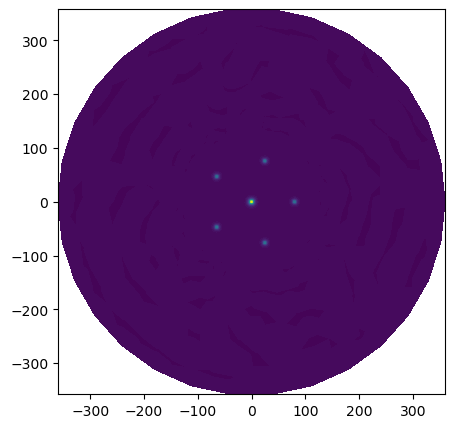

In [16]:
# uf is the final mode amplitudes
# prop.vs[:,:,-1] is the final eigenbasis

output_field = np.sum(uf[None,:]*prop.vs[:,:,-1],axis=1)
from wavesolve.fe_solver import plot_eigenvector

plot_eigenvector(prop.mesh,np.real(output_field))

Looks good!

## **4. Worked example: directional coupler (dicoupler)** 

### **4.1 Dicoupler review**

The simplest directional coupler is composed of two embedded single-mode channels, which are "squeezed" to some minimum core-to-core separation over a given length, which we will call the "coupling length". Along the coupling length, power between the channels oscillates. If the overall waveguide is symmetric, the net power transfer between the cores can vary from 0 to 1, and will oscillate sinusoidally with the coupling length.

This same behavior can also be viewed using the supermode basis, which is the basis `cbeam` uses. When the two channels are widely separated, the two supermodes of the waveguides are the same as the fundamental modes of each isolated single-mode channel (assuming the supermodes are not degenerate; if they are, you can choose two supermodes such that this is the case). When the two channels are squeezed together, the supermode structure changes: the first supermode is a symmetric combination of the two channel modes, while the second is antisymmetric. Furthermore, even if the two supermodes were originally degenerate, they will develop a slight difference in effective index in the coupling region.

A wavefront originally confined to one channel of a symmetric dicoupler will evenly excite both the symmetric and antisymmetric supermodes. Due to the difference in effective index, the supermodes beat against each other. The net effect is an apparent oscillation in power between the dicoupler channels --- as claimed above. As the coupling length changes, the amount of phase beating changes, which in turn changes the power splitting ratio of the dicoupler.

### **4.2 Simulation**

We will use the pre-made `Dicoupler` class simulate a dicoupler. First, let's define our parameters.

In [9]:
### symmetric dicoupler propagation parameters ###

wl = 1.55                       # wavelength, um
dmin = 10.                      # minimum center-to-center separation of single mode channels
dmax = 60.                      # maximum center-to-center separation of single mode channels
coupling_length = 5000.         # length of coupling region (where SM channels are close)
bend_length = coupling_length/2.5         # approximate length of channel bends

rcore = 3.                      # core radius. we will simulate a symmetric dicoupler, so core radii of both channels are the same

nclad = 1.444                   # cladding refractive index
ncore = nclad + 8.8e-3          # SM core refractive index

# mesh params #
core_res = 60                      # no. of line segments to use to resolve the core-cladding interface(s)
clad_mesh_size = 5.0               # mesh size (triangle side length) to use in the cladding region
core_mesh_size = 1.0               # mesh size (triangle side length) to use inside the cores

# solve params #
tol = 1e-4
min_zstep = 1.25
max_zstep = 320.

Note that for the `Dicoupler` class, we specify a coupling length, not the overall waveguide length. The overall waveguide length is auto-computed (in this basic implementation, it's two times the coupling length) and can be accessed through `Dicoupler.z_ex`. 
Let's make the dicoupler and inspect the paths. I've made a built-in plotting function for this.

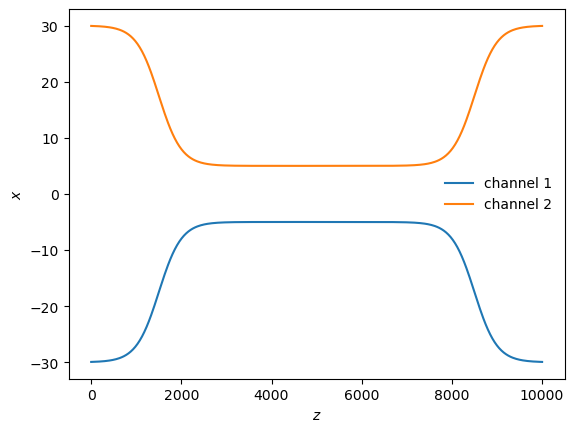

In [10]:
import waveguide

dicoupler = waveguide.Dicoupler(rcore,rcore,ncore,ncore,dmax,dmin,nclad,coupling_length,bend_length,core_res,core_mesh_size=core_mesh_size,clad_mesh_size=clad_mesh_size)

dicoupler.plot_paths()

Next, we'll initialize the propagator.

In [11]:
import propagator
adprop = propagator.Propagator(wl,dicoupler,Nmax=2)

Let's run the setup and save the output to `"test_dicoupler"`. This takes around 11 minutes on my machine.

generating mesh...
number of mesh points:  2141
initial mesh: 


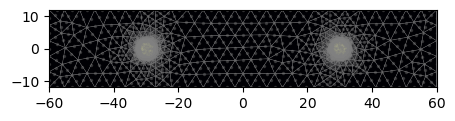

initial modes: 
effective index:  1.4474928486616283


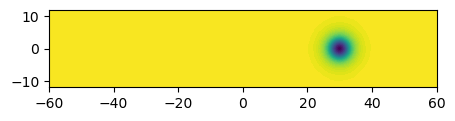

effective index:  1.4474928042173836


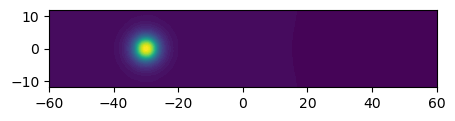

starting computation ...
current z: 10000.0 / 10000.0 ; current zstep: 320.0        time elapsed:  321.4470808506012


In [12]:
output = adprop.prop_setup(0,dicoupler.z_ex,tol,save=True,tag="test_dicoupler",min_zstep=min_zstep,max_zstep=max_zstep,plot=True)

Now, let's propagate, and plot the mode amplitudes as a function of $z$. I'm using a very coarse simulation resolution here to speed things up. We'll inject into the "left" channel. 

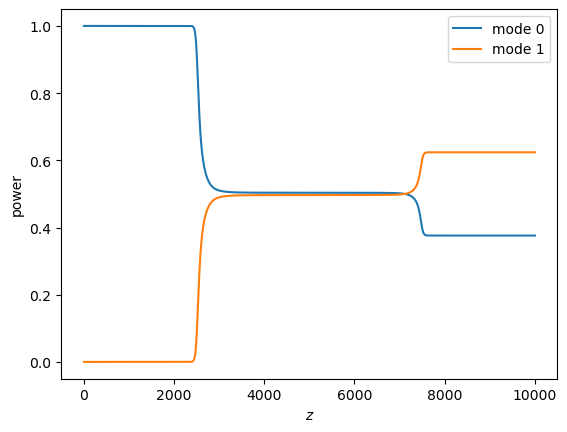

In [13]:
import matplotlib.pyplot as plt
import numpy as np

adprop.make_interp_funcs()

u0 = np.array([1,0],dtype=np.complex128)
z,u,uf = adprop.propagate(u0,dicoupler.z_ex,WKB=True)

plt.plot(z,np.power(np.abs(u[0]),2),label="mode 0")
plt.plot(z,np.power(np.abs(u[1]),2),label="mode 1")
plt.xlabel(r"$z$")
plt.ylabel("power")
plt.legend(loc="best")
plt.show()

We see that upon entering the coupling region, $z\in[2500,7500]$, the amplitude of mode 0 falls and the amplitude of mode 1 rises until both are $\sim 0.5$. This is telling us that the injection of light into a single channel is evenly exciting both supermodes in the coupling region. Upon leaving the cross-coupling region, the mode amplitudes split. The split ratio depends on the coupling length, as we will see later.

For fun, let's also plot the cross-coupling matrix.

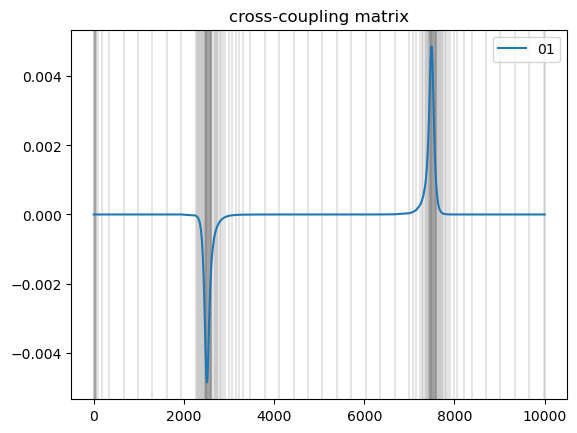

In [18]:
for j in range(2): 
    for i in range(j):
        plt.plot(adprop.za,adprop.cmat[:,i,j],label=str(i)+str(j))

for z in adprop.za: # plot vertical bars at every z value.
    plt.axvline(x=z,alpha=0.1,color='k',zorder=-100)
plt.legend(loc='best')
plt.title("cross-coupling matrix")
plt.show()

We can quickly look at the effect that the coupling length has on the final output powers of the dicoupler by playing some tricks. The `prop_setup()` function returns the eigenmodes, eigenvalues, and cross-coupling matrix over some array of $z$ values. Supposing that everything is well-sampled, we can apply a transformation of our choice to the $z$ array (so long as that transformation preserves monotonicity). In doing so, we are simulating a longitudinal re-scaling of the waveguide structure, while avoiding the need to rerun `prop_setup()`.

I provide an example below. We are interested in the oscillation period of the output powers of the dicoupler as a function of coupling length, for which there are empirical expressions (see the section after this one). The transformation I will apply is to simply split the $z$ array in half, displacing the latter half by some positive amount. 

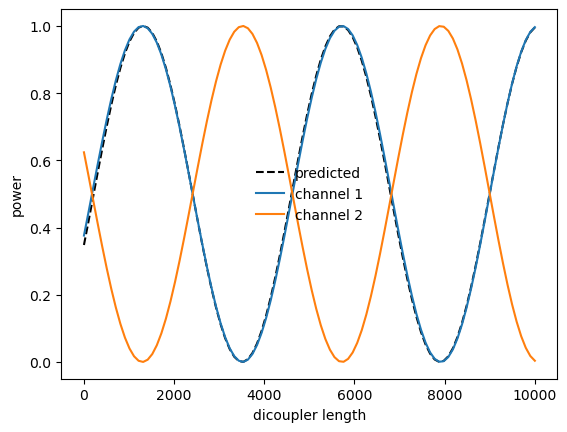

In [16]:
stretch_amounts = np.linspace(0,10000,100)
u0 = np.array([1,0],dtype=np.complex128)
pwrs = []

for i,stretch in enumerate(stretch_amounts):
    za = np.copy(adprop.za)
    za[np.argmax(za>=dicoupler.z_ex/2):] += stretch # stretch out the z array

    adprop.make_interp_funcs(za) # remake the interpolation functions
    z,u,uf = adprop.propagate(u0,za[-1],WKB=True) # rerun the propagator
    
    pwr = np.power(np.abs(uf),2) 
    pwrs.append(pwr)

pwrs = np.array(pwrs)

pred_period = 4390 ## SEE BELOW ##

zmax = stretch_amounts[np.argmax(pwrs[:,0])] # translating the sinusoid to match
plt.plot(stretch_amounts,np.power(np.cos(np.pi/pred_period*(stretch_amounts-zmax)),2),color='k',ls='dashed',label="predicted")

plt.plot(stretch_amounts,pwrs.T[0],label="channel 1")
plt.plot(stretch_amounts,pwrs.T[1],label="channel 2")
plt.legend(loc='best',frameon=False)
plt.xlabel("dicoupler length")
plt.ylabel("power")
plt.title("output of dicoupler channels vs. of coupling length")
plt.show()


In the above plot, I also show a "predicted" power output as a function of length. The derivation can be found in fiber optics textbooks. For an ideal, symmetric dicoupler with light injected solely into channel 1, the output power in channel 1 is 

$$
P_1 = cos^2(\kappa L)
$$

The oscillation wavenumber $\kappa$ has an useful empirical approximation [1]:

$$
\kappa \approx \dfrac{\pi V}{2 k n_{\rm clad} r^2} \exp\left[ -\left(c_0 +c1\frac{d}{a}+c_2\frac{d^2}{a^2} \right) \right]
$$

for $k$ the free-space wavenumber, $r$ the single-mode channel core radius, $d$ the inter-core spacing at minimum separation, and $n_{\rm clad}$ the refractive indexing of the cladding. The fiber $V$ number is defined as 

$$
V = kr\sqrt{n_{\rm core}^2-n_{\rm clad}^2}
$$

where $n_{\rm core}$ is the refractive index of the core material. The empirical constants are defined through:

$$
c_0 = 5.2789 - 3.663 V + 0.3841 V^2
$$

$$
c_1 = -0.7769 + 1.2252 V - 0.0152 V^2
$$

$$
c_2 = −0.0175 − 0.0064 V − 0.0009V^2
$$

For our dicoupler parameters, the predicted period is $\sim 4390$ $\mu {\rm m}$.

*An aside...*

While the oscillation period of our simulated dicoupler matches the theory, the oscillation is not in phase with what is predicted by the theory. I think this is because the theoretical analysis assumes fixed inter-core spacing and neglects the transitioning regions of the dicoupler. Neither of those are true with our model, which assumes $\tanh(z)$ variation for the inter-core spacing and includes the dicoupler bends.


**References**

[1] Govind P. Agrawal, "Applications of Nonlinear Fiber Optics", Chapter 2 - Directional couplers.